### Calculations and plotting for Figure 4

#### import statements

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from matplotlib import colors

In [4]:
import importlib

In [5]:
from project_utils import parameters as param
from project_utils import fig_utils as figu

importlib.reload(figu)
importlib.reload(param)

<module 'project_utils.parameters' from '/oak/stanford/groups/omramom/group_members/fvdav/projects/precip_clustering/project_utils/parameters.py'>

#### set plot configurations

In [6]:
figu.set_plt_rc_params()

### Read data

In [7]:
mflux_dat = xr.open_dataset("../processed_data/moisture_flux.nc")

load class predictions:

In [8]:
class_prob = pd.read_csv("../processed_data/predicted_class_data.csv")

In [9]:
class_prob['date'] = pd.to_datetime(class_prob.date)

In [10]:
ones_dates = class_prob.loc[class_prob.predicted_class == 1].date
zero_dates = class_prob.loc[class_prob.predicted_class == 0].date

### Figure 4: Changes in moisture flux

In [11]:
mflux1 = mflux_dat.sel(time = ones_dates.values)
mflux0 = mflux_dat.sel(time = zero_dates.values)

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
### function to calculate mann-whitney p-value at each grid cell 

def mw_pval(x, y):
    ## xarray ufunc will fill with nans which need to be dropped
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    return mannwhitneyu(x, y).pvalue

def mannwhitneyu_xr(x, y):
    return xr.apply_ufunc(mw_pval, x, y, 
                          input_core_dims = [["time"], ["time"]], ## dimension to be reduced 
                          vectorize = True, 
                          ## necessary to specify joins and fill value because time dimensions do not match
                         join = "outer", dataset_join = "outer",
                         dataset_fill_value = np.nan,
                         )



In [14]:
pval_ds = xr.Dataset({"pval_epcp":
                      mannwhitneyu_xr(mflux1.sel(time = param.early_years).mag, 
                                      mflux1.sel(time = param.late_years).mag), 
                     "pval_nonepcp":
                      mannwhitneyu_xr(mflux0.sel(time = param.early_years).mag, 
                                      mflux0.sel(time = param.late_years).mag)})

pval_ds["nonsig_epcp"] = xr.ones_like(pval_ds.pval_epcp).where(abs(pval_ds.pval_epcp) >= 0.05)
pval_ds["nonsig_nonepcp"] = xr.ones_like(pval_ds.pval_nonepcp).where(abs(pval_ds.pval_nonepcp) >= 0.05)

In [15]:
import cartopy.io.shapereader as sr

In [16]:
region_shp_file = "../processed_data/region.shp"

In [17]:
plt.rc('hatch', color='#505050', linewidth = 0.5)

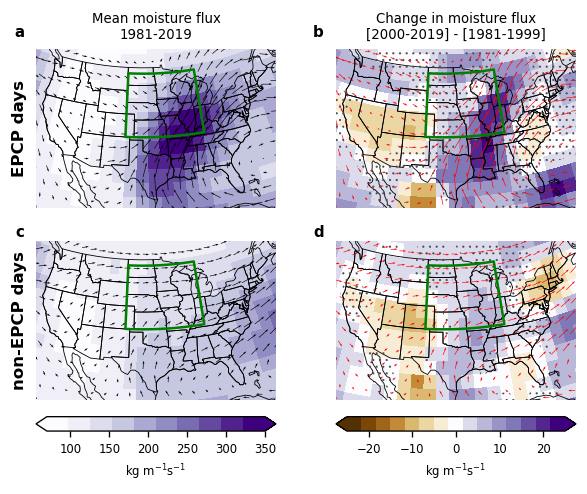

In [18]:
fig = plt.figure(figsize = (5, 4)) 
                        #subplot_kw={'projection': figu.mapcrs}, sharex = True, sharey = True)

ax = fig.add_axes([0.05, 0.55, 0.4, 0.4], projection =figu.mapcrs)
p = ax.pcolormesh(param.lons, param.lats, mflux1['mag'].mean(dim = 'time'), 
                  cmap = figu.purples, transform = ccrs.PlateCarree(), vmin = 70, vmax = 350)
ax.quiver(param.lons, param.lats, mflux1['u_dir'].mean(dim = 'time').values,  
                    mflux1['v_dir'].mean(dim = 'time').values,
                 transform = ccrs.PlateCarree(), scale_units = 'height', scale = 2000)
ax.add_geometries(sr.Reader(region_shp_file).geometries(), 
                  crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = figu.region_col, linewidth = 1.5, zorder = 20)
figu.format_map(ax, bounds = figu.small_bounds)
figu.add_panel_label(ax, 'a', x = -0.05)
ax.set(title = "Mean moisture flux\n1981-2019")
ax.text(x = -0.1, y = 0.5, s = 'EPCP days', transform = ax.transAxes, rotation = "vertical", va = "center", fontweight = "bold")

ax = fig.add_axes([0.55, 0.55, 0.4, 0.4], projection =figu.mapcrs)
p = ax.pcolormesh(param.lons, param.lats, mflux1.sel(time = param.late_years)['mag'].mean(dim = 'time') - 
                  mflux1.sel(time = param.early_years)['mag'].mean(dim = 'time'), 
                  cmap = figu.brownpurple, transform = ccrs.PlateCarree(), vmin = -25, vmax = 25)
ax.contourf(param.lons, param.lats, pval_ds['nonsig_epcp'], levels = (0,2),
                  hatches = ["..."], alpha = 0, colors = "gray", 
                  transform = ccrs.PlateCarree(), zorder = 10)
ax.quiver(param.lons, param.lats, mflux1['u_dir'].sel(time = param.late_years).mean(dim = 'time').values,  
                    mflux1['v_dir'].sel(time = param.late_years).mean(dim = 'time').values,
                 transform = ccrs.PlateCarree(), scale_units = 'height', scale = 2000, color = "red")
ax.add_geometries(sr.Reader(region_shp_file).geometries(), 
                  crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = figu.region_col, linewidth = 1.5, zorder = 20)
figu.format_map(ax, bounds = figu.small_bounds)
figu.add_panel_label(ax, 'b', x = -0.05)
ax.set(title = "Change in moisture flux\n[2000-2019] - [1981-1999]")

ax = fig.add_axes([0.05, 0.15, 0.4, 0.4], projection =figu.mapcrs)
p = ax.pcolormesh(param.lons, param.lats, mflux0['mag'].mean(dim = 'time'), 
                  cmap = figu.purples, transform = ccrs.PlateCarree(), vmin = 70, vmax = 350)
ax.quiver(param.lons, param.lats, mflux0['u_dir'].mean(dim = 'time').values,  
                    mflux0['v_dir'].mean(dim = 'time').values,
                 transform = ccrs.PlateCarree(), scale_units = 'height', scale = 2000)
ax.add_geometries(sr.Reader(region_shp_file).geometries(), 
                  crs = ccrs.PlateCarree(), facecolor = 'none', 
                  edgecolor = figu.region_col, linewidth = 1.5, zorder = 20)
ax.text(x = -0.1, y = 0.5, s = 'non-EPCP days', transform = ax.transAxes, 
        rotation = "vertical", va = "center", fontweight = "bold")
figu.format_map(ax, bounds = figu.small_bounds)
figu.add_panel_label(ax, 'c', x = -0.05, y = 1.1)
cbaxes = fig.add_axes([0.05, 0.12, 0.4, 0.03]) 
fig.colorbar(p, cax = cbaxes, extend = "both", label = "kg $\mathregular{m^{-1} s^{-1}}$", orientation = "horizontal")

ax = fig.add_axes([0.55, 0.15, 0.4, 0.4], projection = figu.mapcrs)
p = ax.pcolormesh(param.lons, param.lats, mflux0.sel(time = param.late_years)['mag'].mean(dim = 'time') - 
                  mflux0.sel(time = param.early_years)['mag'].mean(dim = 'time'), 
                  cmap = figu.brownpurple, transform = ccrs.PlateCarree(), vmin = -25, vmax = 25)
ax.contourf(param.lons, param.lats, pval_ds['nonsig_nonepcp'], levels = (0,2),
                  hatches = ["..."], alpha = 0, colors = "gray", 
                  transform = ccrs.PlateCarree(), zorder = 10)
ax.quiver(param.lons, param.lats, mflux0['u_dir'].sel(time = param.late_years).mean(dim = 'time').values,  
                    mflux0['v_dir'].sel(time = param.late_years).mean(dim = 'time').values,
                 transform = ccrs.PlateCarree(), scale_units = 'height', scale = 2000, color = "red")
ax.add_geometries(sr.Reader(region_shp_file).geometries(), 
                  crs = ccrs.PlateCarree(), facecolor = 'none', 
                  edgecolor = figu.region_col, linewidth = 1.5, zorder = 20)
figu.format_map(ax, bounds = figu.small_bounds)
figu.add_panel_label(ax, 'd', x = -0.05, y = 1.1)
cbaxes = fig.add_axes([0.55, 0.12, 0.4, 0.03]) 
fig.colorbar(p, cax = cbaxes, extend = "both", label = "kg $\mathregular{m^{-1} s^{-1}}$", orientation = "horizontal")
 
fig.savefig("../figures/figure_4.pdf")